<a href="https://colab.research.google.com/github/Chenxi-yi/deep-learning-/blob/master/pretrained_model_resnet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 
"""### 挂载到google drive上""" 
from google.colab import drive

# 使用工具colab的接口挂载google drive目录，这样可以从外部获取数据并且可以把训练好的模型保存在google drive上
drive.mount('/content/gdrive')
#model.save('/content/gdrive/My Drive/DL/mnist_model.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install torchnet

In [0]:
# path="/content/gdrive/My Drive/DL/small set"
path="/content/gdrive/My Drive/DL/10Knots"

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision import models
from torchvision.models import ResNet
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

In [0]:
def load_split_train_test(path,valid_size = 0.2):
  train_trainsforms = transforms.Compose([#transforms.RandomResizedCrop(256),# formal 224
                                            transforms.Resize((256,256)), # resize
                                            transforms.RandomHorizontalFlip(), # random horizontal flip
                                            #transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                            mean=(0.485, 0.456, 0.406), # formal (0.485, 0.456, 0.406)
                                            std=(0.229, 0.224, 0.225))  # formal (0.229, 0.224, 0.225)
                                                     ])
  test_trainsforms = transforms.Compose([#transforms.RandomResizedCrop(256),
                                            transforms.Resize((256,256)),
                                            transforms.RandomHorizontalFlip(),
                                            #transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                            mean=(0.485, 0.456, 0.406),
                                            std=(0.229, 0.224, 0.225))
                                                     ])
  
  '''
   train_trainsforms = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),])
    test_trainsforms = transforms.Compose([transforms.Resize((224,224)),                                      
                                           transforms.ToTensor(),])
  
  '''

  train_data = datasets.ImageFolder(path,transform=train_trainsforms)
  print("train_data size：",train_data[0][0].size())       # 查看resize(确保图像都有3通道)
  test_data = datasets.ImageFolder(path,transform=test_trainsforms)

  num_train = len(train_data)                               # 训练集数量
  indices = list(range(num_train))                          # 训练集索引

  split = int(np.floor(valid_size * num_train))             # 获取20%数据作为验证集
  np.random.shuffle(indices)                                # 打乱数据集

  from torch.utils.data.sampler import SubsetRandomSampler
  train_idx, test_idx = indices[split:], indices[:split]    # 获取训练集，测试集
  train_sampler = SubsetRandomSampler(train_idx)            # 打乱训练集，测试集
  test_sampler  = SubsetRandomSampler(test_idx)

    #============数据加载器：加载训练集，测试集===================
  batch_size = 4
  train_loader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)
  test_loader = DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)
  return train_loader,test_loader

In [6]:
train_loader,test_loader = load_split_train_test(path, 0.2)
print(train_loader.dataset.classes)

train_data size： torch.Size([3, 256, 256])
['Alpine Butterfly Knot', 'Bowline Knot', 'Clove Hitch', 'Figure-8 Knot', 'Figure-8 Loop', "Fisherman's Knot", 'Flemish Bend', 'Overhand Knot', 'Reef Knot', 'Slip Knot']


In [0]:
class_names = train_loader.dataset.classes

In [0]:
# show the picture


In [0]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

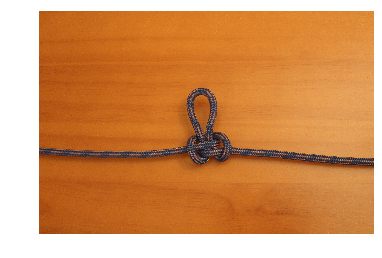

In [9]:
# Example image

x = Image.open(path + '/Alpine Butterfly Knot/IMG_6322.jpg')
np.array(x).shape
imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Overhand Knot Overhand Knot Alpine Butterfly Knot Clove Hitch


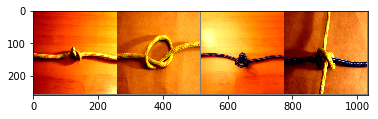

In [10]:
# view the train set
import numpy as np
 
# functions to show an image
 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
 
 
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
batch_size = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))
images, labels = images.to(device), labels.to(device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  Clove Hitch Bowline Knot Bowline Knot Slip Knot


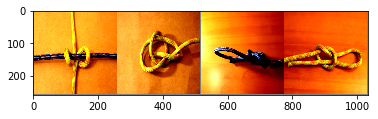

In [11]:
# view the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
 
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))
images, labels = images.to(device), labels.to(device)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('trian_device:{}'.format(device.type))

trian_device:cuda


In [0]:
from torchvision import models
model = models.vgg16(pretrained=True)

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
import torch.nn as nn
# Add on classifier
n_inputs = model.classifier[6].in_features
n_classes = 10
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
 model = model.to('cuda')

In [0]:
from torch import optim
# Loss and optimizer
criteration = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [18]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224), batch_size=4, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 224, 224]           1,792
              ReLU-2          [4, 64, 224, 224]               0
            Conv2d-3          [4, 64, 224, 224]          36,928
              ReLU-4          [4, 64, 224, 224]               0
         MaxPool2d-5          [4, 64, 112, 112]               0
            Conv2d-6         [4, 128, 112, 112]          73,856
              ReLU-7         [4, 128, 112, 112]               0
            Conv2d-8         [4, 128, 112, 112]         147,584
              ReLU-9         [4, 128, 112, 112]               0
        MaxPool2d-10           [4, 128, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]         295,168
             ReLU-12           [4, 256, 56, 56]               0
           Conv2d-13           [4, 256, 56, 56]         590,080
             ReLU-14           [4, 256,

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()
    
    # confusion matrix
    confusion_matrix = meter.ConfusionMeter(10)
    
    
    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()
        
        # confusion matrix
        confusion_matrix.reset()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()   
            
            # Update the parameters
            optimizer.step()
            
             # confusion matrix
            confusion_matrix.add(output.data, target.data)

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
            

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    
                    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    #print(train_loader.dataset.classes)
    print(str(confusion_matrix.value()))
    #cm = str(confusion_matrix.value())
    cm = confusion_matrix.value()
    # plt
    plt.subplots(figsize=(10, 10)) # 设置画面大小
    sns.heatmap(cm, annot=True, vmax=1, square=True, cmap="Blues")
    num_local = np.array(range(10))
    labels_name = train_loader.dataset.classes
    plt.xticks(num_local, labels_name, rotation=90)
    plt.yticks(num_local, labels_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.savefig('./cm.png')
    plt.show()
    
    
    
    
    
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.3889 	Validation Loss: 0.2428
		Training Accuracy: 30.28%	 Validation Accuracy: 10.62%

Epoch: 1 	Training Loss: 0.9937 	Validation Loss: 0.1821
		Training Accuracy: 44.24%	 Validation Accuracy: 14.03%

Epoch: 2 	Training Loss: 0.8501 	Validation Loss: 0.1663
		Training Accuracy: 50.76%	 Validation Accuracy: 14.44%

Epoch: 3 	Training Loss: 0.8191 	Validation Loss: 0.1491
		Training Accuracy: 50.90%	 Validation Accuracy: 15.69%

Epoch: 4 	Training Loss: 0.7665 	Validation Loss: 0.1512
		Training Accuracy: 52.43%	 Validation Accuracy: 14.79%

Epoch: 5 	Training Loss: 0.7672 	Validation Loss: 0.1448
		Training Accuracy: 53.19%	 Validation Accuracy: 15.21%

Epoch: 6 	Training Loss: 0.7126 	Validation Loss: 0.1258
		Training Accuracy: 54.44%	 Validation Accuracy: 15.69%

Epoch: 7 	Training Loss: 0.7146 	Validation Loss: 0.1315
		Training Accuracy: 55.07%	 Validation Accuracy: 15.76%

Epoch: 8 	Training Loss: 0.7111 	Validation Lo

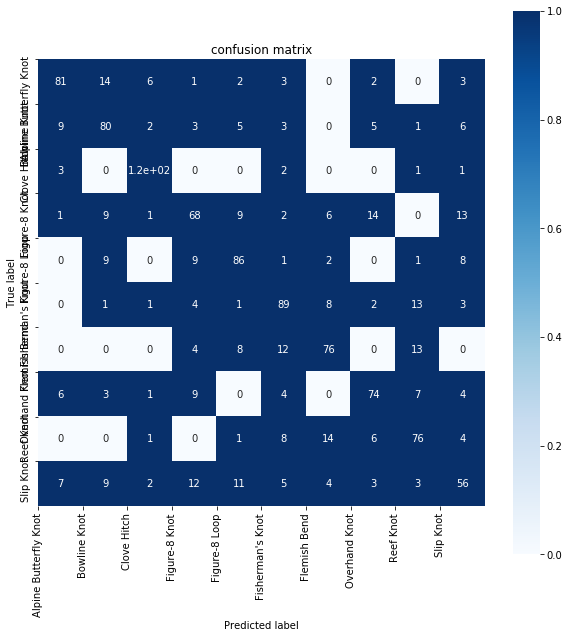

In [21]:
from timeit import default_timer as timer
from torchnet import meter
import seaborn as sns
import matplotlib.pyplot as plt
save_file_name = 'vgg16-transfer.pt'
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=1)

Text(0.5, 1.0, 'Training and Validation Losses')

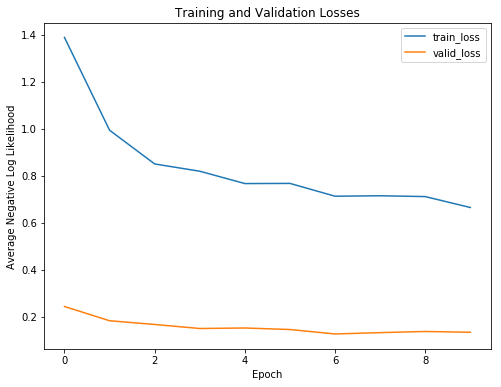

In [23]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

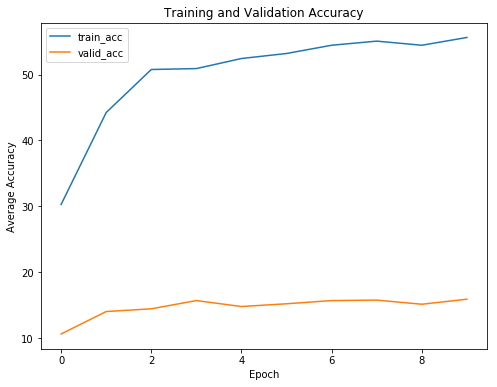

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 288 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 288 test images: 79 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size = 4
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]),
          'class_correct = ',class_correct[i],
         'class_total = ',class_total[i])
  

Accuracy of Alpine Butterfly Knot : 90 % class_correct =  29.0 class_total =  32.0
Accuracy of Bowline Knot : 53 % class_correct =  16.0 class_total =  30.0
Accuracy of Clove Hitch : 100 % class_correct =  22.0 class_total =  22.0
Accuracy of Figure-8 Knot : 90 % class_correct =  19.0 class_total =  21.0
Accuracy of Figure-8 Loop : 71 % class_correct =  20.0 class_total =  28.0
Accuracy of Fisherman's Knot : 90 % class_correct =  20.0 class_total =  22.0
Accuracy of Flemish Bend : 83 % class_correct =  26.0 class_total =  31.0
Accuracy of Overhand Knot : 91 % class_correct =  33.0 class_total =  36.0
Accuracy of Reef Knot : 70 % class_correct =  24.0 class_total =  34.0
Accuracy of Slip Knot : 62 % class_correct =  20.0 class_total =  32.0
